# Criteria to select genes and cells

- eliminate proliferating cell types (not interested in proliferating cell states)
- remake the gene lists based on the DE new criteria (wilcox, pval threshold, sorted by logfc)

In [1]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
import anndata
import seaborn as sns
#import scvelo as scv

#import milopy.core as milo
#import milopy.plot as milopl


In [2]:
sc.set_figure_params(dpi=50, dpi_save=600) # Makes it more visible

In [3]:
tmpfile = '../h5ad_files/LYMPHOID_ALL_wilcox_tmp.h5ad'

In [4]:
adata = sc.read_h5ad('h5ad_files/PAN.A01.v01.raw_count.20210429.LYMPHOID.embedding.h5ad')
adata

AnnData object with n_obs × n_vars = 241950 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'dendrogram_scvi_clusters', 'scvi'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [5]:
cells = {
    'PRO_B',# : "Bcells",
    'LATE_PRO_B',# : "Bcells",
    'LARGE_PRE_B',# : "Bcells",
    'SMALL_PRE_B',# : "Bcells",
    'IMMATURE_B',# : "Bcells",
    'MATURE_B',# : "Bcells",
    'B1',# : "Bcells",
    'PLASMA_B',# : "Bcells",
    'PRE_PRO_B',# : "Bcells",
    'NK',# : "NKcells",
    'DN(early)_T',# : "Dev_Tcells",
    'DN(Q)_T',# : "Dev_Tcells",
    'DN(P)_T',# : "Dev_Tcells",
    'DP(P)_T',# : "Dev_Tcells",
    'DP(Q)_T',# : "Dev_Tcells",
    'ABT(ENTRY)',# : "Dev_Tcells",
    'ILC2',# : "ILCs",
    'ILC3',# : "ILCs",
    'CD4+T',# : "Tcells",
    'CD8+T',# : "Tcells",
    'TREG',# : "Tcells",
    'TYPE_1_INNATE_T',# : "Tcells_unc",
    'TYPE_3_INNATE_T',# : "Tcells_unc",
    'CD8AA',# : "Tcells_unc",
 }

In [6]:
Lymp = adata[adata.obs['anno_lvl_2_final_clean'].isin(cells)]

In [7]:
Lymp.obs['anno_lvl_2_final_clean'] = Lymp.obs['anno_lvl_2_final_clean'].cat.reorder_categories(cells)

/home/irepan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  """Entry point for launching an IPython kernel.


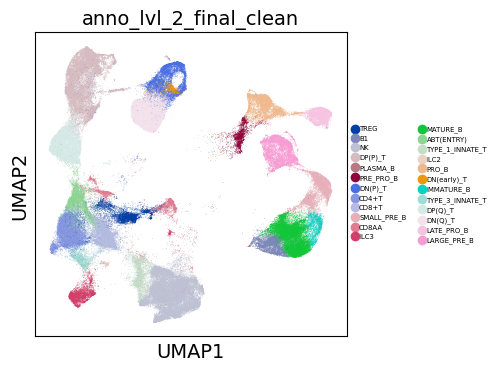

In [8]:
sc.pl.umap(Lymp, color="anno_lvl_2_final_clean",legend_fontsize= 5  )

In [9]:
del adata

In [10]:
sc.pp.normalize_per_cell(Lymp, counts_per_cell_after=10e4)
sc.pp.log1p(Lymp)

In [11]:
#pip install --user scikit-misc
#sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor= "seurat_v3" )min_mean :
sc.settings.verbosity = 4
sc.pp.highly_variable_genes(Lymp, min_mean=0.3, max_mean=5)

extracting highly variable genes
    Gene indices [8872, 9886, 25342] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:28)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


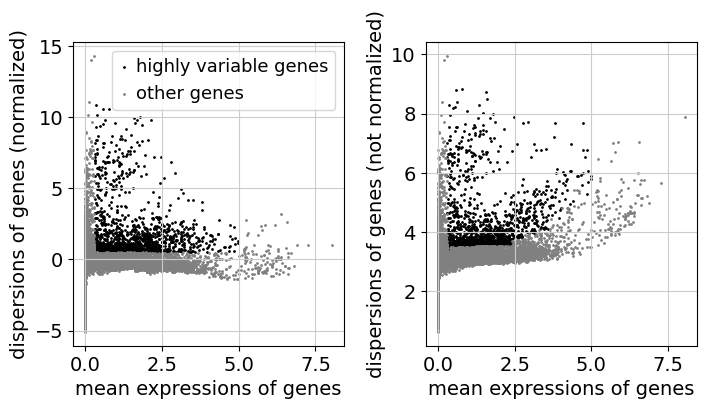

In [12]:
sc.pl.highly_variable_genes(Lymp)

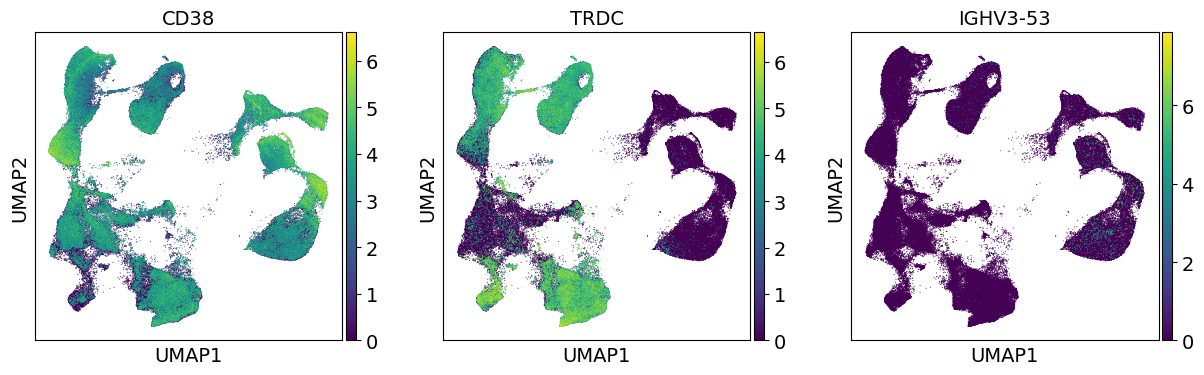

In [13]:
sc.pl.umap(Lymp, color= ["CD38", "TRDC","IGHV3-53"], size=2 ) # top

### Perform comparison between t-test and wilcox data

ranking genes
    consider 'anno_lvl_2_final_clean' groups:
    with sizes: [ 6850  5652 30284 22839    61  3019  9810 13649  9369  8263  4737  5931
 17489  7066  5727   468  8113  1670  2689  3031 12390 13655  6340 10468]
    finished: added to `.uns['t-test']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:56)


/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:399: Pe

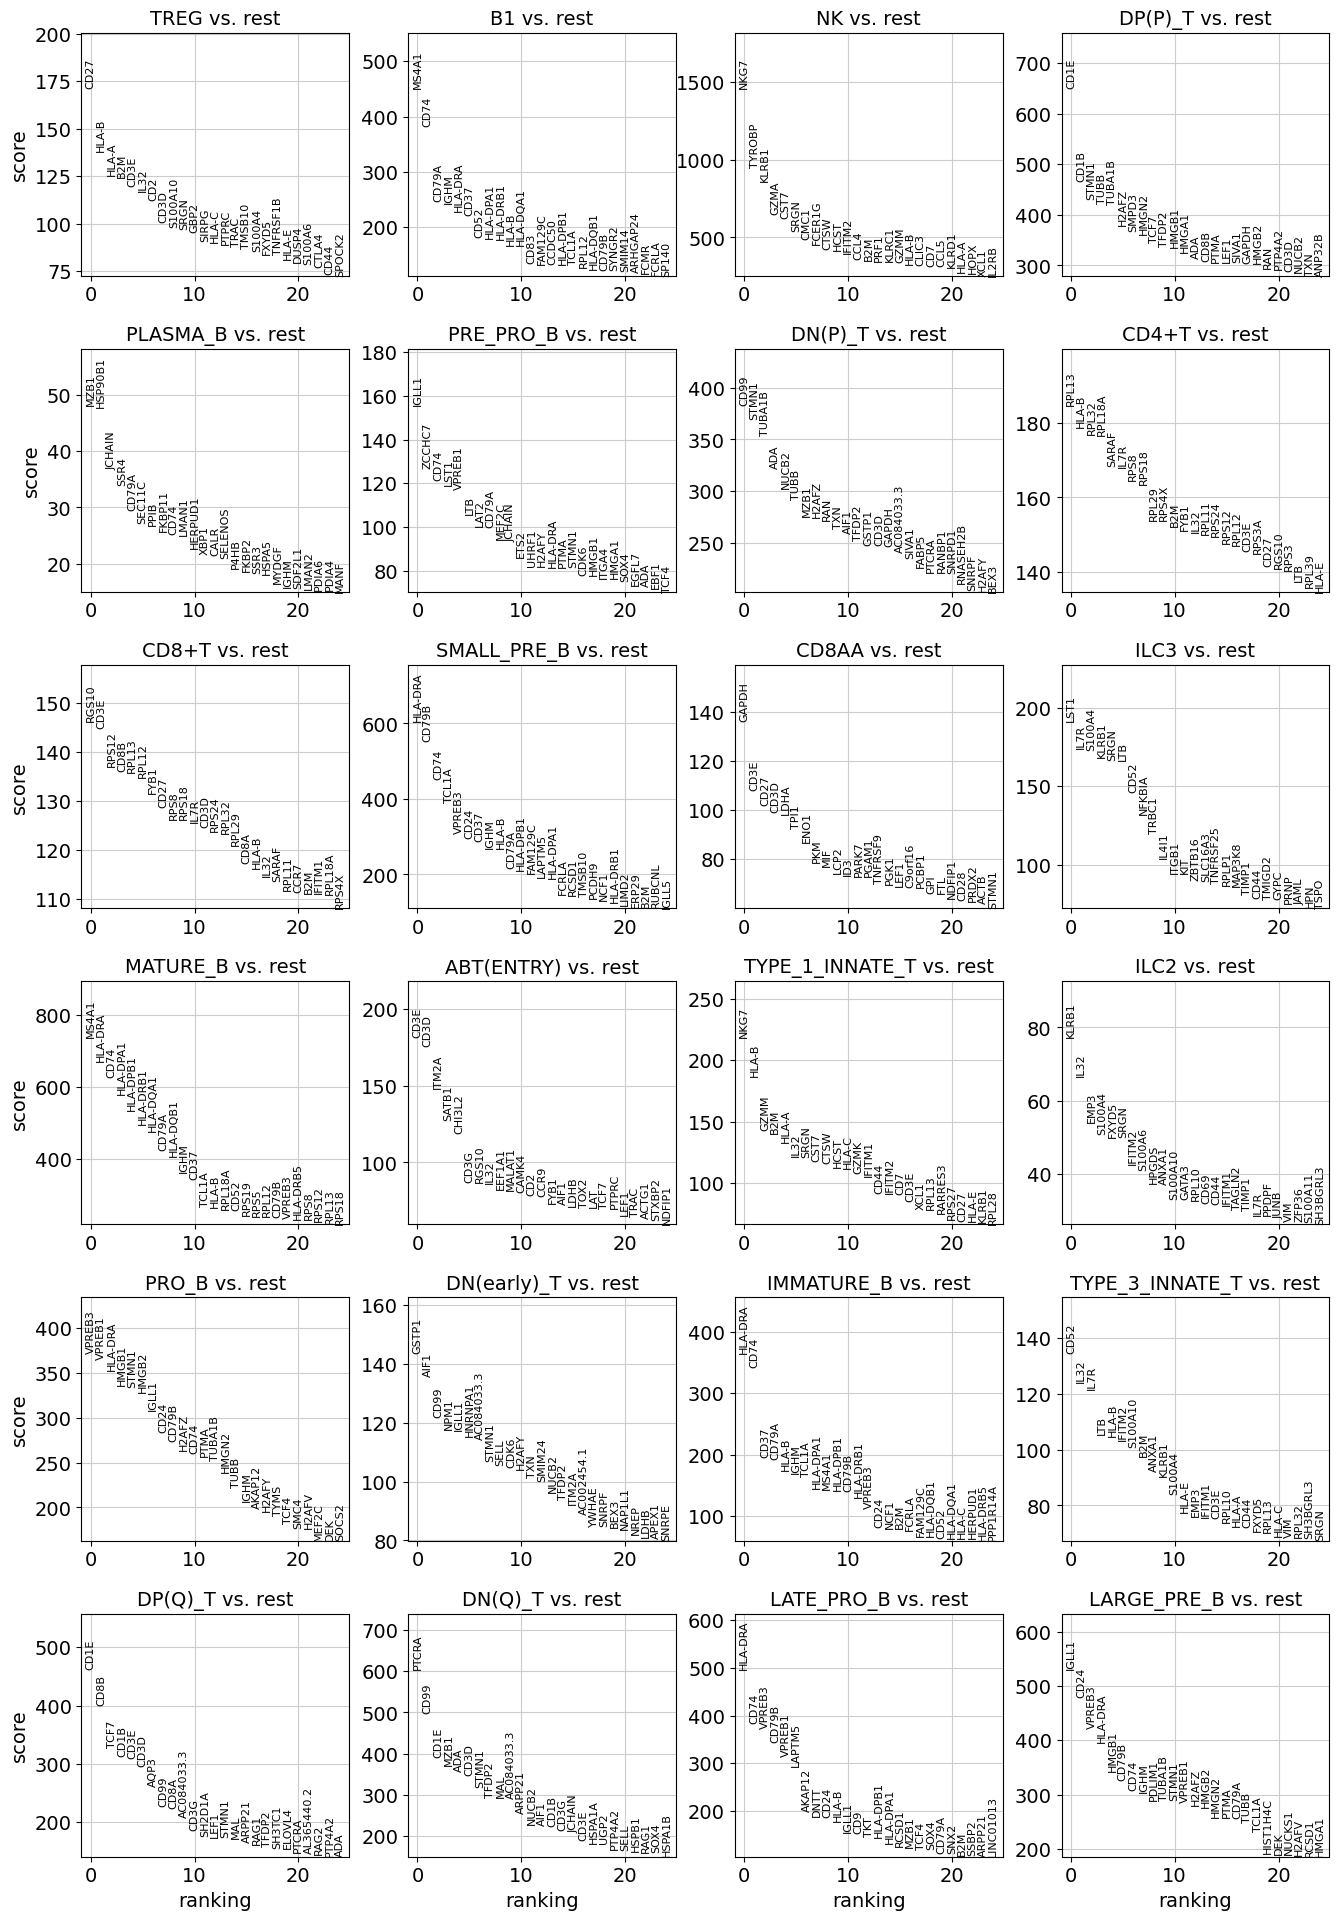

In [14]:
sc.tl.rank_genes_groups(Lymp, groupby= 'anno_lvl_2_final_clean', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(Lymp, n_genes=25, sharey=False, key = "t-test")

ranking genes
    consider 'anno_lvl_2_final_clean' groups:
    with sizes: [ 6850  5652 30284 22839    61  3019  9810 13649  9369  8263  4737  5931
 17489  7066  5727   468  8113  1670  2689  3031 12390 13655  6340 10468]
    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:11:01)


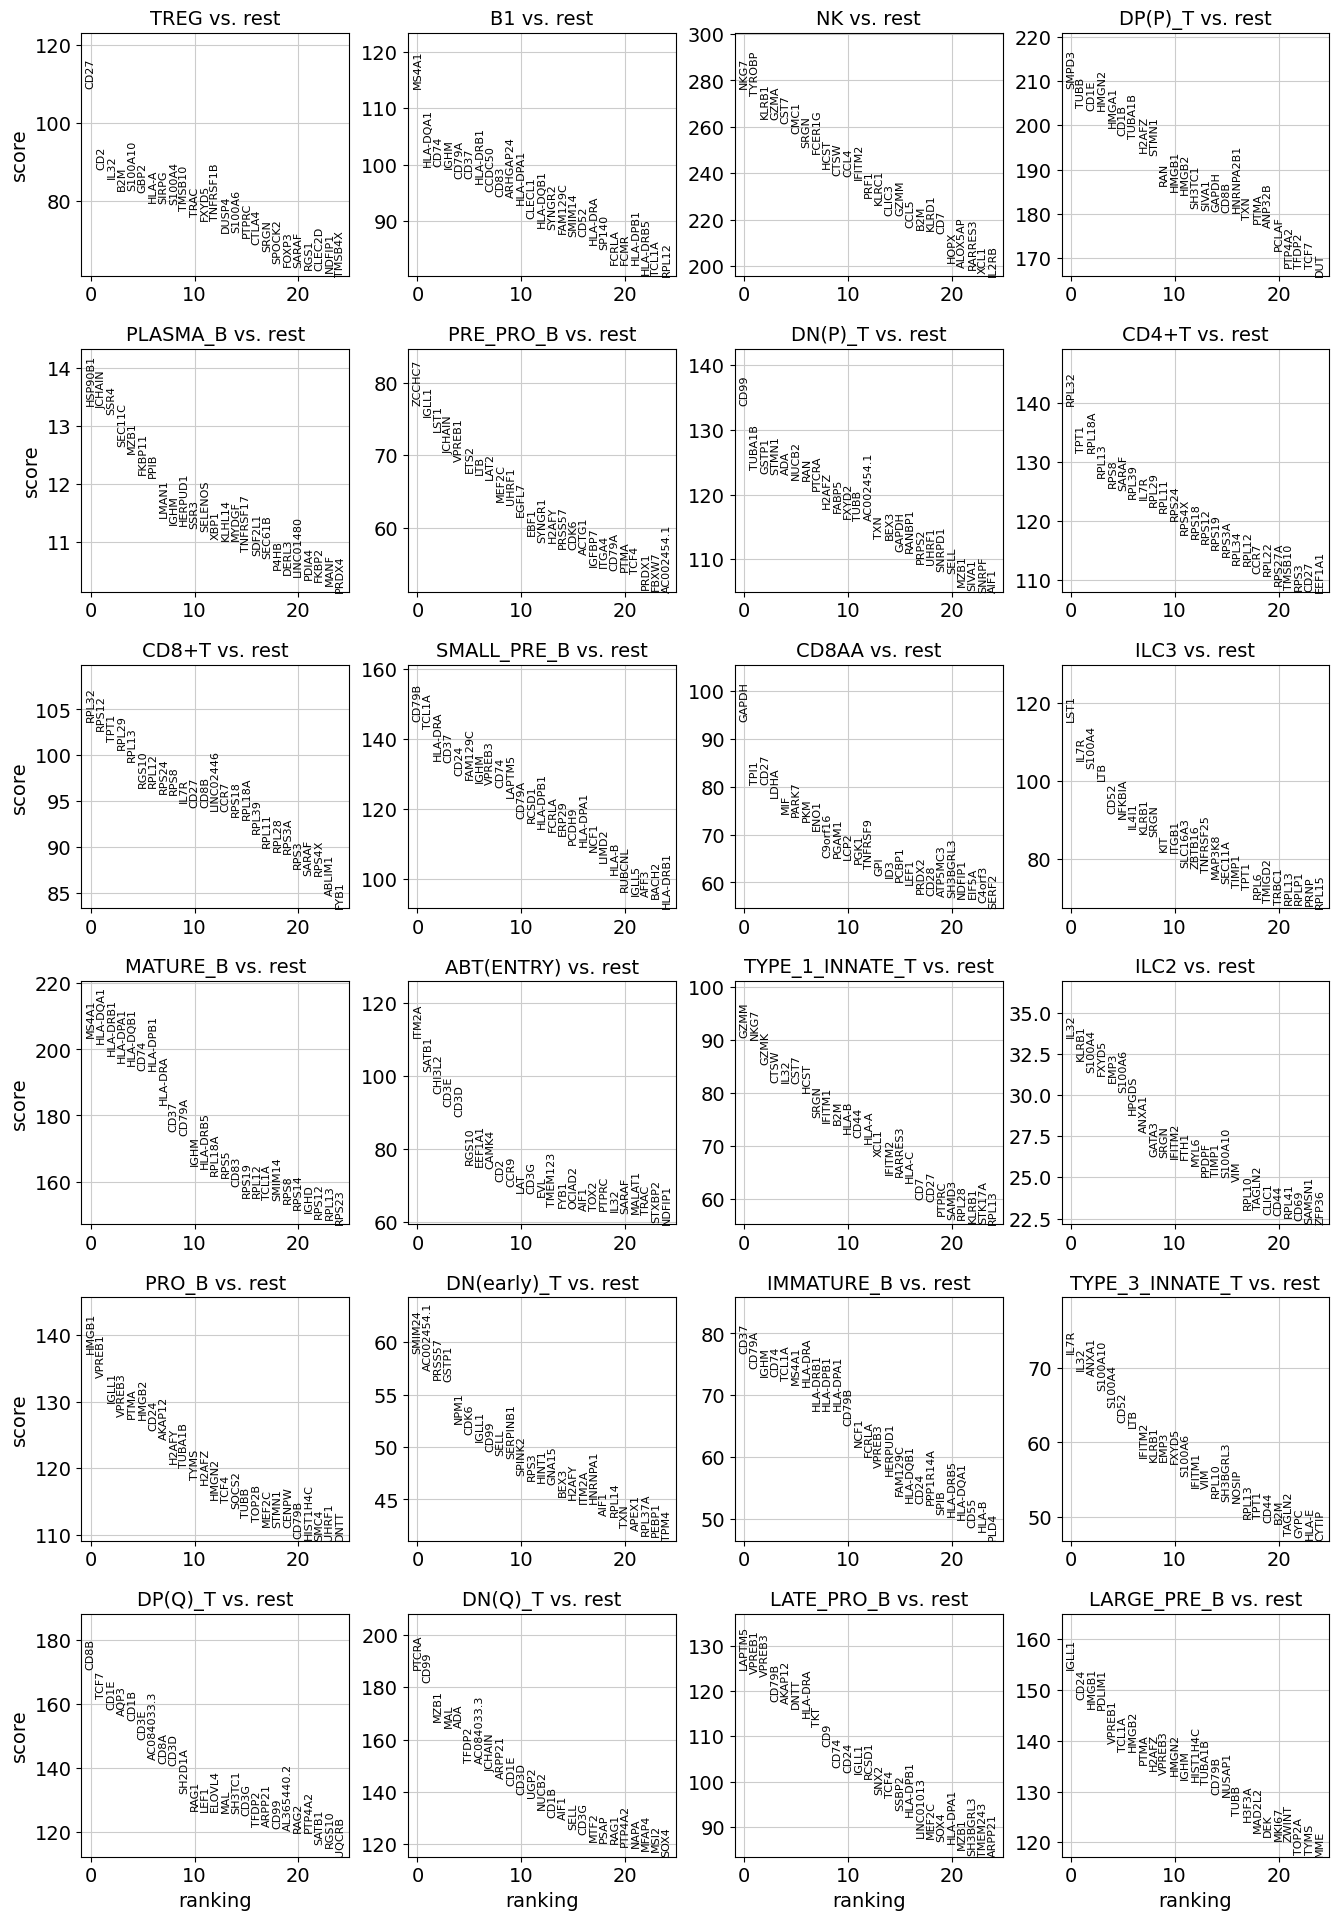

In [15]:
sc.tl.rank_genes_groups(Lymp, groupby= 'anno_lvl_2_final_clean', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(Lymp, n_genes=25, sharey=False, key = "wilcoxon")

In [16]:
Lymp.write(tmpfile)

## Read preprocessed data

In [4]:
adata = sc.read_h5ad(tmpfile)

In [11]:
for clust in adata.obs.anno_lvl_2_final_clean.cat.categories: 
    f = "./DE_genelists_log2FC/LYMPHOID_ALL/" + clust + ".csv"
    df = sc.get.rank_genes_groups_df(adata, group=clust,
                                    key='wilcoxon')
    df.to_csv(f, sep=",")

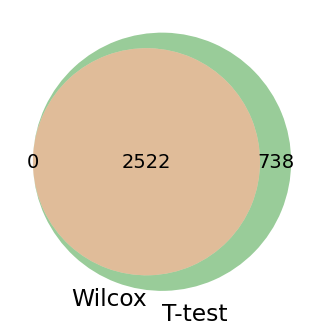

In [5]:
#compare PRO_B genes
from matplotlib_venn import venn2

wc = sc.get.rank_genes_groups_df(adata, group='PRO_B', key='wilcoxon', pval_cutoff=0.0001, log2fc_min=1)
tt = sc.get.rank_genes_groups_df(adata, group='PRO_B', key='t-test', pval_cutoff=0.0001, log2fc_min=1)

venn2([set(wc['names']),set(tt['names'])], ('Wilcox','T-test') )
plt.show()

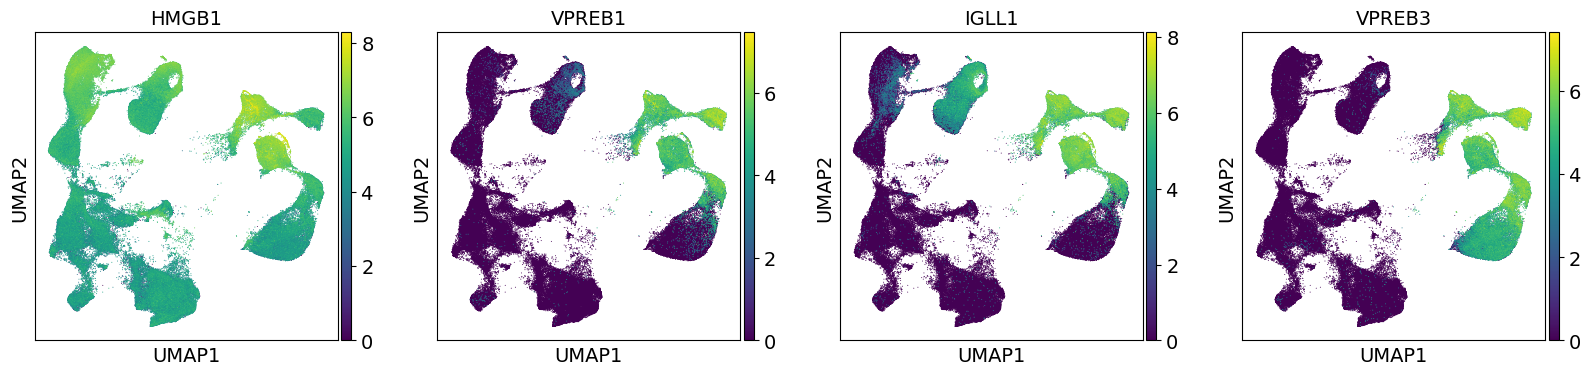

In [7]:
sc.pl.umap(adata, color= wc["names"][0:4], size=2 ) # top

## Create a matrix with the average expression for each cell type

In [27]:
res = pd.DataFrame(columns=adata.var_names, index=adata.obs['anno_lvl_2_final_clean'].cat.categories)                                                                                                 

for clust in adata.obs.anno_lvl_2_final_clean.cat.categories: 
    res.loc[clust] = adata[adata.obs['anno_lvl_2_final_clean'].isin([clust]),:].X.mean(0)

In [28]:
res

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,AL691520.1,AC139491.7,AC021097.2,AL590381.1,AC003043.2,AL356417.3,AC010616.2,AL034430.1,AP000646.1,AP006216.3
TREG,0.089239,0.00035,0.579912,0.171616,0.132091,0.011692,0.000344,0.183554,0.118208,0.201592,...,0.0,0.000312,0.0,0.0,0.0,0.005634,0.0,0.0,0.0,0.0
B1,0.013031,0.0,0.645024,0.188107,0.083635,0.230937,0.001357,0.128226,0.088409,0.229722,...,0.0,0.000365,0.0,0.0,0.0,0.004799,0.0,0.0,0.0,0.0
NK,0.003521,0.0,0.437723,0.143897,0.021243,1.567701,0.00624,0.199871,0.081666,0.143806,...,0.0,0.0,0.0,0.0,0.000974,0.017133,0.0,0.0,0.000177,0.00036
DP(P)_T,0.228382,0.0,1.491871,0.213165,0.810912,0.046612,0.028976,0.144907,0.12742,0.358311,...,0.0,0.000336,0.000099,0.0,0.0,0.002052,0.0,0.0,0.001311,0.0
PLASMA_B,0.01973,0.0,0.789968,0.105657,0.148199,0.022426,0.0,0.308551,0.145979,0.325746,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PRE_PRO_B,0.012874,0.000958,1.143698,0.176916,0.296858,0.020658,0.009491,0.188599,0.20396,0.39967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001063,0.0
DN(P)_T,0.084888,0.000437,1.535348,0.209093,0.690712,0.039886,0.44146,0.168897,0.166723,0.380536,...,0.0,0.00033,0.0,0.0,0.000816,0.003192,0.000173,0.0,0.000425,0.0
CD4+T,0.099986,0.0,0.498493,0.171347,0.034867,0.005554,0.012143,0.075335,0.06296,0.198054,...,0.0,0.0,0.0,0.0,0.000276,0.004263,0.0,0.0,0.0,0.0
CD8+T,0.156692,0.000907,0.575517,0.175574,0.053962,0.012574,0.006147,0.055911,0.092457,0.211835,...,0.0,0.0,0.00058,0.0,0.0,0.00528,0.0,0.0,0.00091,0.000335
SMALL_PRE_B,0.000859,0.0,0.454781,0.09036,0.021927,0.031957,0.000392,0.043935,0.0342,0.139387,...,0.0,0.003477,0.0,0.0,0.000363,0.005781,0.0,0.0,0.0,0.000455


In [29]:
res = np.round(res, decimals= 3)

In [31]:
res.to_csv("Lymphoid_all_Avg_expression.csv")

## Loop to produce the lists of Lymphoid lineages

In [9]:
Subtypes = adata.obs['anno_lvl_2_final_clean'].unique()
Subtypes

['LARGE_PRE_B', 'PRE_PRO_B', 'PRO_B', 'CD4+T', 'CD8+T', ..., 'DP(Q)_T', 'DN(P)_T', 'PLASMA_B', 'DN(early)_T', 'DN(Q)_T']
Length: 24
Categories (24, object): ['TREG', 'B1', 'NK', 'DP(P)_T', ..., 'DP(Q)_T', 'DN(Q)_T', 'LATE_PRO_B', 'LARGE_PRE_B']

In [10]:
for i in range(0,len(Subtypes)):
    print(i, Subtypes[i])

0 LARGE_PRE_B
1 PRE_PRO_B
2 PRO_B
3 CD4+T
4 CD8+T
5 TREG
6 NK
7 ILC3
8 ILC2
9 SMALL_PRE_B
10 MATURE_B
11 B1
12 TYPE_1_INNATE_T
13 IMMATURE_B
14 LATE_PRO_B
15 DP(P)_T
16 TYPE_3_INNATE_T
17 CD8AA
18 ABT(ENTRY)
19 DP(Q)_T
20 DN(P)_T
21 PLASMA_B
22 DN(early)_T
23 DN(Q)_T


### Marker genes for each Subtype

In [11]:
Markers = [[]]*len(Subtypes)

for i in range(0,len(Subtypes)):
    print(i, Subtypes[i])
    m = sc.get.rank_genes_groups_df(adata, group=Subtypes[i],
                                    key='wilcoxon', pval_cutoff=0.0001,
                                    log2fc_min=1)
    m = m.sort_values("logfoldchanges", ascending=False)
    m.reset_index(drop=True, inplace=True)
    Markers[i] = m

0 LARGE_PRE_B
1 PRE_PRO_B
2 PRO_B
3 CD4+T
4 CD8+T
5 TREG
6 NK
7 ILC3
8 ILC2
9 SMALL_PRE_B
10 MATURE_B
11 B1
12 TYPE_1_INNATE_T
13 IMMATURE_B
14 LATE_PRO_B
15 DP(P)_T
16 TYPE_3_INNATE_T
17 CD8AA
18 ABT(ENTRY)
19 DP(Q)_T
20 DN(P)_T
21 PLASMA_B
22 DN(early)_T
23 DN(Q)_T


### Get names of 300 top markers (if possible) for each Subtype

In [12]:
#pip install upsetplot
from upsetplot import from_contents
from upsetplot import UpSet

In [13]:
Sets = [[]]*len(Subtypes)
CompleteSets = [[]]*len(Subtypes)

for i in range(0,len(Subtypes)):
    CompleteSets[i] = Markers[i]['names']
    n = len(Markers[i])
    #print(i, Subtypes[i], n)
    if n > 300 :
        #print("yes")
        Sets[i] = Markers[i].loc[0:299,'names']
    else :
        #print("no")
        Sets[i] = Markers[i].loc[0:n-1,'names']

In [14]:
Dict_markers =  {}
CompleteDict_markers =  {}

for i in range(0,len(Subtypes)):
    Dict_markers[Subtypes[i]] = Sets[i]
    CompleteDict_markers[Subtypes[i]] = CompleteSets[i]

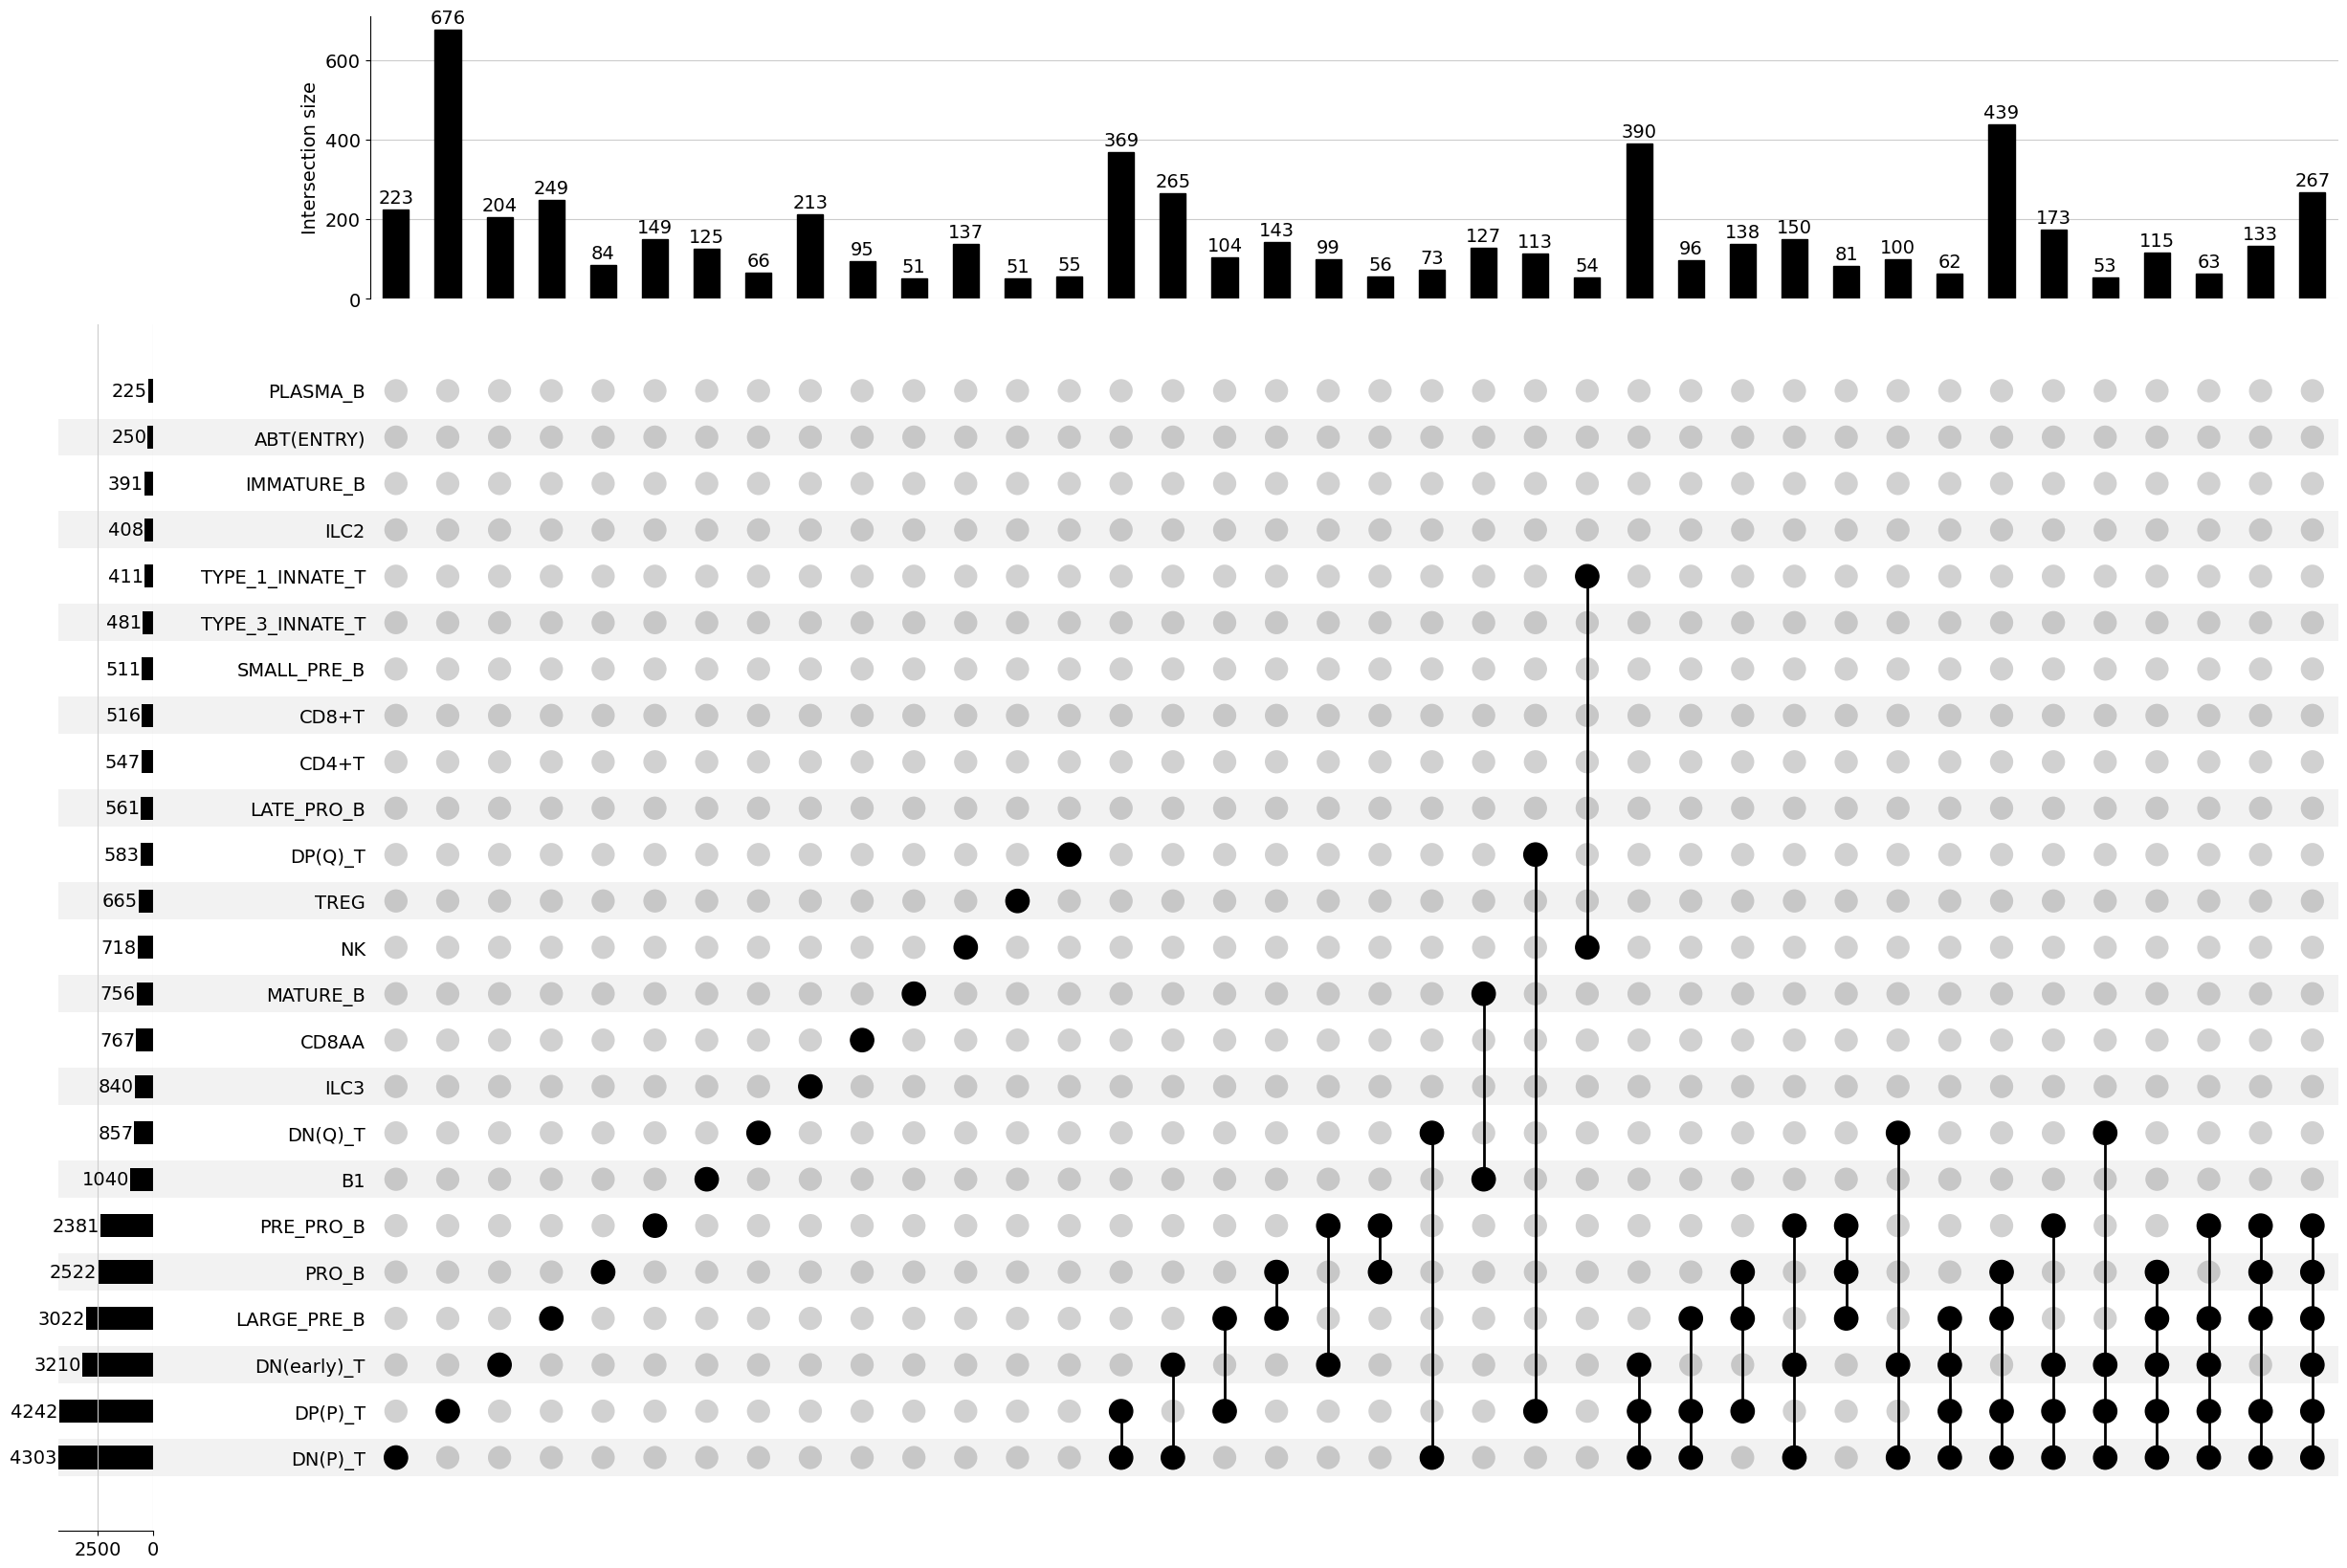

In [15]:
CT_markers = from_contents(CompleteDict_markers)

plt = UpSet(CT_markers, min_subset_size=50, subset_size='count',element_size=50,  show_counts=True).plot()

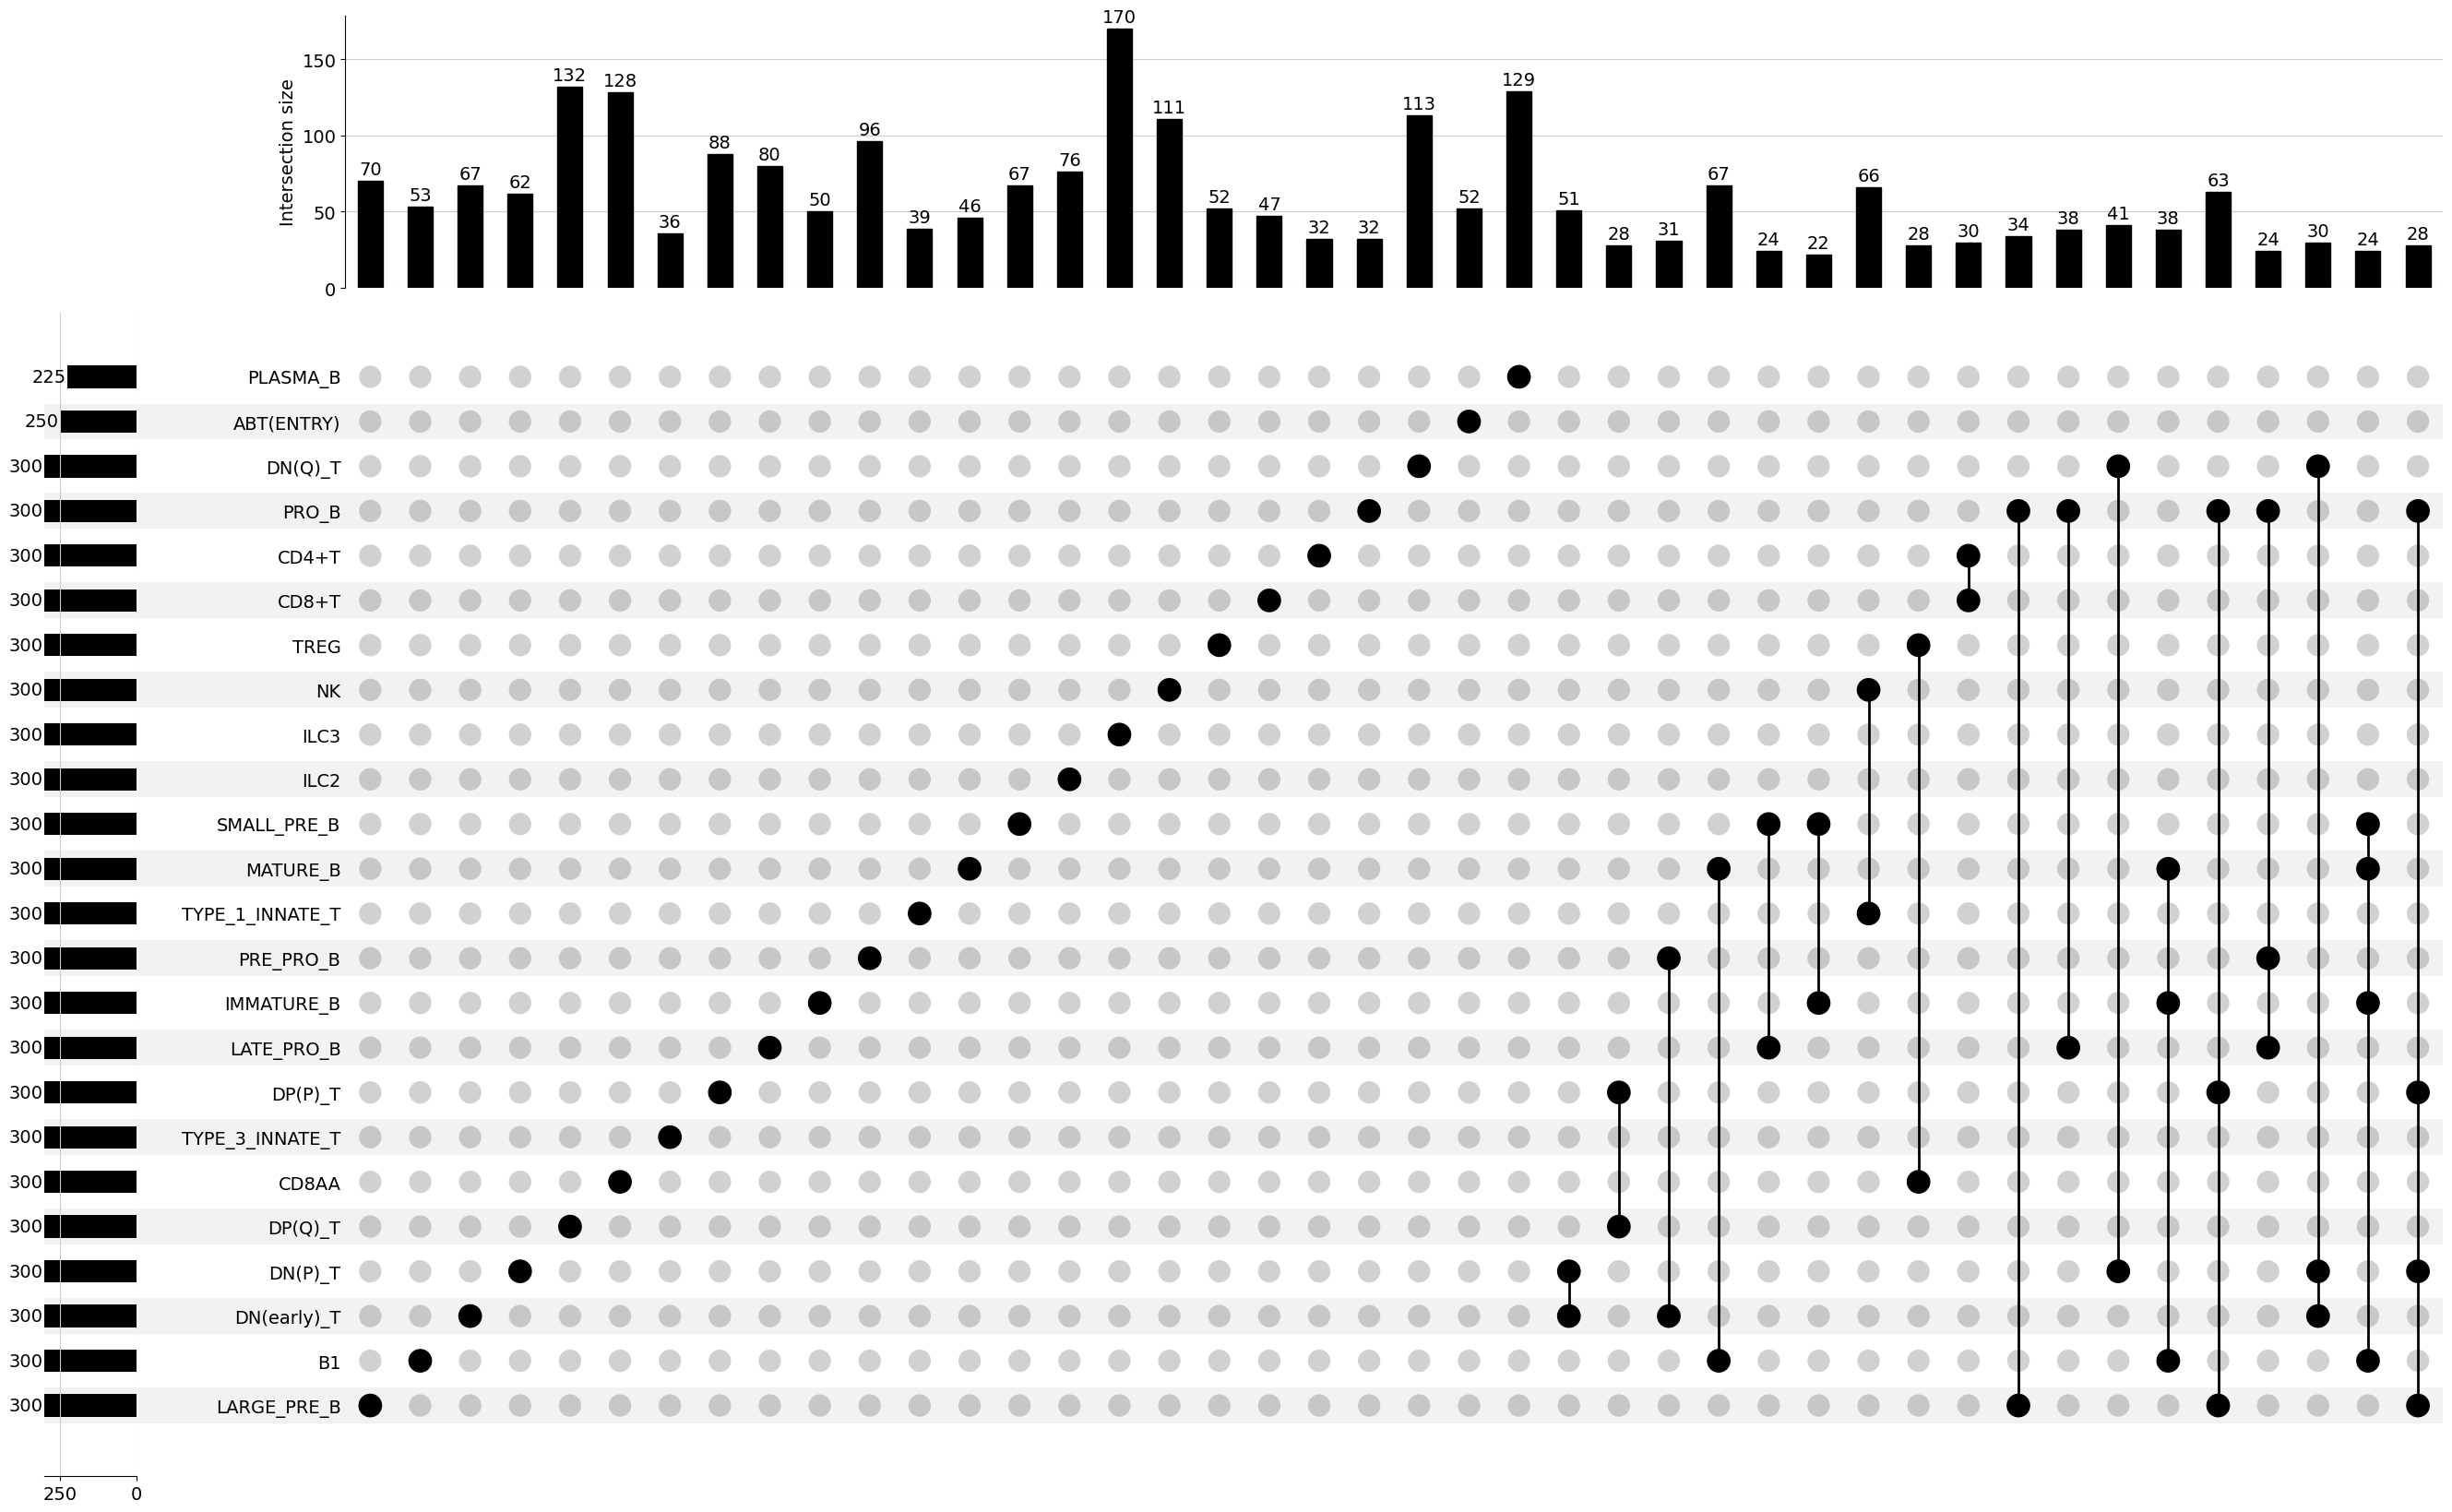

In [16]:
CT_markers = from_contents(Dict_markers)

plt = UpSet(CT_markers, min_subset_size=20, subset_size='count',element_size=50,  show_counts=True).plot()

In [17]:
Dict_markers['ILC2'].loc[0:3]

0     KRT1
1    HPGDS
2     IL13
3    GAP43
Name: names, dtype: object

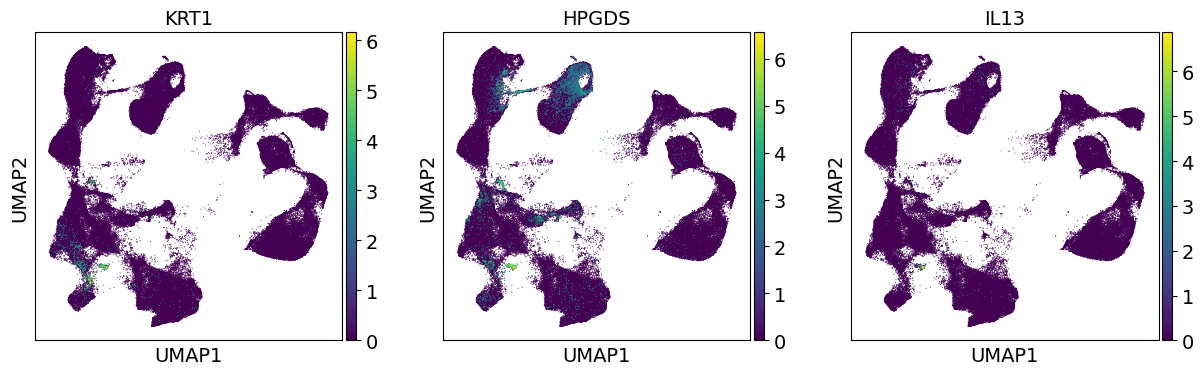

In [18]:
sc.pl.umap(adata, color= ["KRT1", "HPGDS","IL13"], size= 2  ) # top

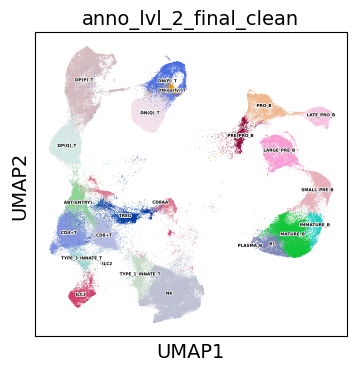

In [19]:
sc.pl.umap(adata, color=["anno_lvl_2_final_clean"],
           legend_loc = 'on data',legend_fontoutline =1,
           save= "Lymphoid_ALL_cells.png", legend_fontsize= 3 )

## create Dataframes for exporting to R and create input files 

In [20]:
# Calling DataFrame constructor after zipping
# both lists, with columns specified
# Calling DataFrame constructor after zipping
# both lists, with columns specified
df = pd.DataFrame(list(zip(Sets[0], Sets[1],  Sets[2], Sets[3], Sets[4], Sets[5],  Sets[6],
                           Sets[7], Sets[8],  Sets[9], Sets[10],Sets[11],Sets[12],Sets[13],
                           Sets[14],Sets[15],Sets[16], Sets[17],#Sets[18],
                           Sets[19],Sets[20],                   #Sets[21],
                           Sets[22], Sets[23])),
               columns =[Subtypes[0], Subtypes[1], Subtypes[2], Subtypes[3], Subtypes[4],
                         Subtypes[5], Subtypes[6], Subtypes[7], Subtypes[8], Subtypes[9],
                         Subtypes[10],Subtypes[11],Subtypes[12],Subtypes[13],Subtypes[14],
                         Subtypes[15],Subtypes[16],Subtypes[17],  #Subtypes[18],
                         Subtypes[19], Subtypes[20],              #Subtypes[21],
                         Subtypes[22],Subtypes[23]])

ABT_ENTRY = pd.DataFrame(list(zip(Sets[18])),columns =[Subtypes[18]])
PLASMA_B  = pd.DataFrame(list(zip(Sets[21])),columns =[Subtypes[21]])

df

,LARGE_PRE_B,PRE_PRO_B,PRO_B,CD4+T,CD8+T,TREG,NK,ILC3,ILC2,SMALL_PRE_B,...,TYPE_1_INNATE_T,IMMATURE_B,LATE_PRO_B,DP(P)_T,TYPE_3_INNATE_T,CD8AA,DP(Q)_T,DN(P)_T,DN(early)_T,DN(Q)_T
0,VAT1L,MEGF10,IGLL1,ST6GALNAC1,LINC02446,AC017002.3,NKG7,HPN,KRT1,TCL1A,...,PRDM16,TCL1A,AC099792.1,SMPD3,ANXA1,GNG4,CD8B,PLA2G3,LINC02573,PTCRA
1,IGLL1,AC125603.2,VPREB1,CD40LG,NELL2,AC133644.2,TYROBP,CHST9,HPGDS,HLA-DRA,...,NKG7,IGHM,VPREB1,CD1E,GNA14,UCA1,CD1E,CTSG,P2RY2,DEFA6
2,TCL1A,TIFAB,NPY,LRRN3,S100B,CTLA4,KLRF1,SCN1B,IL13,ACSM3,...,GZMK,HLA-DRA,DNTT,CD1B,KLRB1,PON3,CD1B,AC002454.1,PRSS57,LINC01819
3,VPREB1,MN1,VPREB3,CTSL,LRRN3,F5,CST7,B3GALT5,GAP43,CD79B,...,TRDV2,MS4A1,DUSP26,TUBA1B,IL32,MAOB,AL390961.1,FXYD2,SNORC,CD1E
4,CD24,SUCNR1,AKAP12,AC005842.1,PASK,FOXP3,CCL4,IL17A,LGALS12,IGHM,...,UNC5B-AS1,CD74,AKAP12,CD8B,IL2,TNFRSF9,ELOVL4,PTCRA,NFE2,MAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,QRSL1,FAAH,PSD3,AAK1,GIMAP8,AC108134.3,CYBA,ARL4A,LDHA,TMEM159,...,FAS,BACH1,GAPT,AC002310.2,ICAM3,PTPRCAP,CDKN2C,SLIRP,APBA2,PWAR6
296,CKAP2,HYAL2,BRCA2,IL16,AC111182.1,RAB25,GPR25,IPCEF1,CARD16,HLA-E,...,LEPROTL1,HSPE1,FADS3,HIRIP3,R3HDM4,ATP8A2,DDX11-AS1,MCM2,PSMB5,PTPN20
297,POLQ,S100A9,NUCKS1,STAT5A,PDCD4,LYPD3,AC245297.3,GYG1,SDCBP,ZHX2,...,GABARAPL1,SYVN1,WASF2,RFC3,SH3YL1,COPG2,SLC8A1-AS1,FP236241.1,CKLF,PCBP3
298,DTL,GLRX,ADGRA3,RNF144A,BCL11B,PTPRJ,SLC4A4,TSPAN2,PGM1,SLC8B1,...,FCMR,MYADM,ZMIZ1,AC011257.1,PECR,GEM,CHD1,CTNND1,RAB34,PACSIN1


In [21]:
# pip install rpy2
# enables the %%R magic, not necessary if you've already done this
%load_ext rpy2.ipython

In [22]:
%%R -i df -w 5 -h 5 --units in -r 200
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution
library("EnsDb.Hsapiens.v86")

head(df)

R[write to console]: Loading required package: ensembldb

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: S4Vectors

R[write to console]: 
Attaching package: ‘S4Vectors’


R[write to cons

  LARGE_PRE_B  PRE_PRO_B  PRO_B      CD4+T     CD8+T       TREG     NK     ILC3
0       VAT1L     MEGF10  IGLL1 ST6GALNAC1 LINC02446 AC017002.3   NKG7      HPN
1       IGLL1 AC125603.2 VPREB1     CD40LG     NELL2 AC133644.2 TYROBP    CHST9
2       TCL1A      TIFAB    NPY      LRRN3     S100B      CTLA4  KLRF1    SCN1B
3      VPREB1        MN1 VPREB3       CTSL     LRRN3         F5   CST7  B3GALT5
4        CD24     SUCNR1 AKAP12 AC005842.1      PASK      FOXP3   CCL4    IL17A
5        IGHM      IGLL1   CD24    ANKRD55      CCR7     ZBTB32   GZMH FAM189A2
     ILC2 SMALL_PRE_B MATURE_B         B1 TYPE_1_INNATE_T IMMATURE_B LATE_PRO_B
0    KRT1       TCL1A    MS4A1     ERICH3          PRDM16      TCL1A AC099792.1
1   HPGDS     HLA-DRA HLA-DQA1      MS4A1            NKG7       IGHM     VPREB1
2    IL13       ACSM3  HLA-DRA      IGHG2            GZMK    HLA-DRA       DNTT
3   GAP43       CD79B HLA-DQB1 AL158850.1           TRDV2      MS4A1     DUSP26
4 LGALS12        IGHM HLA-DRB1   ARHGAP2

In [23]:
%%R

library(stringr)
dim(df)
genelists <- colnames(df)
path <- "~/Desktop/Github/Immune_Adaptation_Atlas/ENS_genelists_wilcox/Lymphoid_ALL/"

for (i in genelists)
    {
    goi <- df[,i]
    #print(i)
    f <- str_remove_all(i, "[()]")
    print(f)
    ens_df <- ensembldb::select(EnsDb.Hsapiens.v86, keys= goi, 
                              keytype = "SYMBOL", 
                              columns = c("SYMBOL","GENEID"))
   
    ens_df <- ens_df$GENEID[grepl(pattern = "^ENS", x = ens_df$GENEID)]
    #print(head(ens_df)) 

    write(x = ens_df, file = paste0(path, f ,"_ENSEMBL.txt"),ncolumns = 1)

    }

[1] "LARGE_PRE_B"
[1] "PRE_PRO_B"
[1] "PRO_B"
[1] "CD4+T"
[1] "CD8+T"
[1] "TREG"
[1] "NK"
[1] "ILC3"
[1] "ILC2"
[1] "SMALL_PRE_B"
[1] "MATURE_B"
[1] "B1"
[1] "TYPE_1_INNATE_T"
[1] "IMMATURE_B"
[1] "LATE_PRO_B"
[1] "DPP_T"
[1] "TYPE_3_INNATE_T"
[1] "CD8AA"
[1] "DPQ_T"
[1] "DNP_T"
[1] "DNearly_T"
[1] "DNQ_T"


In [24]:
%%R -i ABT_ENTRY
# import df from global environment
head(ABT_ENTRY)

goi <- ABT_ENTRY[,1]
f <- str_remove_all(colnames(ABT_ENTRY)[1], "[()]") 
print(f)
ens_df <- ensembldb::select(EnsDb.Hsapiens.v86, keys= goi, 
                            keytype = "SYMBOL", 
                            columns = c("SYMBOL","GENEID"))
   
ens_df <- ens_df$GENEID[grepl(pattern = "^ENS", x = ens_df$GENEID)]
print(head(ens_df)) 

write(x = ens_df, file = paste0(path, f,"_ENSEMBL.txt"),ncolumns = 1)

[1] "ABTENTRY"
[1] "ENSG00000111218" "ENSG00000173585" "ENSG00000078596" "ENSG00000182568"
[5] "ENSG00000124191" "ENSG00000064886"


In [25]:
%%R -i PLASMA_B
# import df from global environment
head(PLASMA_B)

goi <- PLASMA_B[,1]
f <- str_remove_all(colnames(PLASMA_B)[1], "[()]") 
print(f)
ens_df <- ensembldb::select(EnsDb.Hsapiens.v86, keys= goi, 
                            keytype = "SYMBOL", 
                            columns = c("SYMBOL","GENEID"))
   
ens_df <- ens_df$GENEID[grepl(pattern = "^ENS", x = ens_df$GENEID)]
print(head(ens_df)) 

write(x = ens_df, file = paste0(path, f,"_ENSEMBL.txt"),ncolumns = 1)

[1] "PLASMA_B"
[1] "ENSG00000132465" "ENSG00000211899" "ENSG00000282657" "ENSG00000187033"
[5] "ENSG00000115884" "ENSG00000184451"


## Export full list of marker genes

In [26]:
full_csv_path = '/home/irepan/Desktop/Github/Immune_Adaptation_Atlas/ENS_FULL_genelists_wilcox/Lymphoid_ALL/full.csv'

(pd.DataFrame.from_dict(data=CompleteDict_markers, orient='index')
   .to_csv(full_csv_path, header=False))

In [27]:
%%R -i full_csv_path
library("EnsDb.Hsapiens.v86")
library(stringr)

path <- "~/Desktop/Github/Immune_Adaptation_Atlas/ENS_FULL_genelists_wilcox/Lymphoid_ALL/"

mycsv <- read.csv(full_csv_path, row.names = 1,header = F, na.strings = "")

for (i in 1:nrow(mycsv))
{
    genelist <- row.names(mycsv)[i]
    n <- sum(!is.na(mycsv[i,]))
    #print(paste0(n," genes"))
    
    goi <- as.character(mycsv[i,1:n])
    print(goi[1:5])

    f <- str_remove_all(genelist, "[()]")
    print(f)
    ens_df <- ensembldb::select(EnsDb.Hsapiens.v86, keys= goi, 
                              keytype = "SYMBOL", 
                              columns = c("SYMBOL","GENEID"))
   
    ens_df <- ens_df$GENEID[grepl(pattern = "^ENS", x = ens_df$GENEID)]
    #print(head(ens_df)) 

    write(x = ens_df, file = paste0(path, f ,"_FULL_ENSEMBL.txt"),ncolumns = 1)

}


[1] "VAT1L"  "IGLL1"  "TCL1A"  "VPREB1" "CD24"  
[1] "LARGE_PRE_B"
[1] "MEGF10"     "AC125603.2" "TIFAB"      "MN1"        "SUCNR1"    
[1] "PRE_PRO_B"
[1] "IGLL1"  "VPREB1" "NPY"    "VPREB3" "AKAP12"
[1] "PRO_B"
[1] "ST6GALNAC1" "CD40LG"     "LRRN3"      "CTSL"       "AC005842.1"
[1] "CD4+T"
[1] "LINC02446" "NELL2"     "S100B"     "LRRN3"     "PASK"     
[1] "CD8+T"
[1] "AC017002.3" "AC133644.2" "CTLA4"      "F5"         "FOXP3"     
[1] "TREG"
[1] "NKG7"   "TYROBP" "KLRF1"  "CST7"   "CCL4"  
[1] "NK"
[1] "HPN"     "CHST9"   "SCN1B"   "B3GALT5" "IL17A"  
[1] "ILC3"
[1] "KRT1"    "HPGDS"   "IL13"    "GAP43"   "LGALS12"
[1] "ILC2"
[1] "TCL1A"   "HLA-DRA" "ACSM3"   "CD79B"   "IGHM"   
[1] "SMALL_PRE_B"
[1] "MS4A1"    "HLA-DQA1" "HLA-DRA"  "HLA-DQB1" "HLA-DRB1"
[1] "MATURE_B"
[1] "ERICH3"     "MS4A1"      "IGHG2"      "AL158850.1" "ARHGAP24"  
[1] "B1"
[1] "PRDM16"    "NKG7"      "GZMK"      "TRDV2"     "UNC5B-AS1"
[1] "TYPE_1_INNATE_T"
[1] "TCL1A"   "IGHM"    "HLA-DRA" "MS4A1"   "CD74"  